In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### `graph`와 `subgraph` 정의
- `parent graph`
- `parent graph`에 의해 호출될 `child subgraph`
- `child graph`에 의해 호출될 `grandchild subgraph`

### `grandchild` 정의

In [6]:
from typing import TypedDict
from langgraph.graph.state import StateGraph, START, END

class GrandChildState(TypedDict):
    my_grandchild_key: str


def grandchild_1(state: GrandChildState) -> GrandChildState:
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}

grandchild = StateGraph(GrandChildState)

grandchild.add_node("grandchild_1", grandchild_1)


grandchild.add_edge(START, "grandchild_1")

grandchild.add_edge("grandchild_1", END)


grandchild_graph = grandchild.compile()

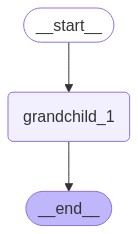

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        grandchild_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [8]:
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "Hi, Teddy!"}, subgraphs=True
):
    print(chunk)

((), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})


In [10]:
class ChildState(TypedDict):
    my_child_key: str


def call_grandchild_graph(state: ChildState) -> ChildState:
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key" : f'([Child]){grandchild_graph_output["my_grandchild_key"]}'}


In [12]:
child = StateGraph(ChildState)

child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)

child_graph = child.compile()

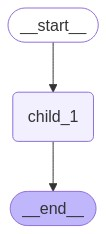

In [13]:
display(
    Image(
        child_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:
for chunk in child_graph.stream(
    {"my_child_key": "Hi, Teddy!"}, subgraphs=True
):
    print(chunk)


(('child_1:0935f8f9-385d-a787-7e51-e964f34552e9',), {'grandchild_1': {'my_grandchild_key': '([GrandChild] Hi, Teddy!)'}})
((), {'child_1': {'my_child_key': '([Child])([GrandChild] Hi, Teddy!)'}})


In [16]:
class ParentState(TypedDict):
    my_parent_key: str


def parent_1(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}

def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


def call_child_graph(state: ParentState) -> ParentState:
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


parent = StateGraph(ParentState)

parent.add_node("parent_1", parent_1)
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)


parent_graph = parent.compile()

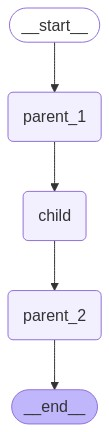

In [17]:
display(
    Image(
        parent_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [18]:
for chunk in parent_graph.stream(
    {"my_parent_key": "Hi, Teddy!"}, subgraphs=True
):
    print(chunk)




((), {'parent_1': {'my_parent_key': '([Parent1] Hi, Teddy!)'}})
(('child:ac833b76-c4ea-bd04-012d-ce0848da2a46', 'child_1:8fcb4d1b-c1ed-4bd9-9963-32532d1d8033'), {'grandchild_1': {'my_grandchild_key': '([GrandChild] ([Parent1] Hi, Teddy!))'}})
(('child:ac833b76-c4ea-bd04-012d-ce0848da2a46',), {'child_1': {'my_child_key': '([Child])([GrandChild] ([Parent1] Hi, Teddy!))'}})
((), {'child': {'my_parent_key': '([Child])([GrandChild] ([Parent1] Hi, Teddy!))'}})
((), {'parent_2': {'my_parent_key': '([Parent2] ([Child])([GrandChild] ([Parent1] Hi, Teddy!)))'}})
